<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Robust-Regression" data-toc-modified-id="Robust-Regression-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Robust Regression</a></span></li><li><span><a href="#Step-2---Define-the-descriptive-statistical-model-\begin{align*}
y_i-&amp;\sim-Student(\nu,-\mu,-\sigma)-
\\-\nu--&amp;\sim-Gamma(2,-1)
\\-\mu_i-&amp;=-\beta_0-+-\beta_1x-+-\beta_2x
\\-\beta_0-&amp;\sim-normal(0,-1)
\\-\beta_1-&amp;\sim-normal(0,-1)
\\-\beta_2-&amp;\sim-normal(0,-1)-
\\-\sigma-&amp;\sim-Exponential(1)
\end{align*}" data-toc-modified-id="Step-2---Define-the-descriptive-statistical-model-\begin{align*}
y_i-&amp;\sim-Student(\nu,-\mu,-\sigma)-
\\-\nu--&amp;\sim-Gamma(2,-1)
\\-\mu_i-&amp;=-\beta_0-+-\beta_1x-+-\beta_2x
\\-\beta_0-&amp;\sim-normal(0,-1)
\\-\beta_1-&amp;\sim-normal(0,-1)
\\-\beta_2-&amp;\sim-normal(0,-1)-
\\-\sigma-&amp;\sim-Exponential(1)
\end{align*}-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Step 2 - Define the descriptive statistical model <script type="math/tex; mode=display" id="MathJax-Element-15">\begin{align*}
y_i &\sim Student(\nu, \mu, \sigma) 
\\ \nu  &\sim Gamma(2, 1)
\\ \mu_i &= \beta_0 + \beta_1x + \beta_2x
\\ \beta_0 &\sim normal(0, 1)
\\ \beta_1 &\sim normal(0, 1)
\\ \beta_2 &\sim normal(0, 1) 
\\ \sigma &\sim Exponential(1)
\end{align*}</script></a></span></li><li><span><a href="#Step-4---Use-Bayes-rule." data-toc-modified-id="Step-4---Use-Bayes-rule.-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Step 4 - Use Bayes rule.</a></span></li><li><span><a href="#Stan-model-of-a-Bayesian-robust-regression" data-toc-modified-id="Stan-model-of-a-Bayesian-robust-regression-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Stan model of a Bayesian robust regression</a></span></li><li><span><a href="#Step-5---Posterior-predictive-checks" data-toc-modified-id="Step-5---Posterior-predictive-checks-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Step 5 - Posterior predictive checks</a></span><ul class="toc-item"><li><span><a href="#posterior-p-values" data-toc-modified-id="posterior-p-values-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>posterior p-values</a></span></li></ul></li><li><span><a href="#Reporting-the-results-of-the-Bayesian-robust-regression" data-toc-modified-id="Reporting-the-results-of-the-Bayesian-robust-regression-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Reporting the results of the Bayesian robust regression</a></span><ul class="toc-item"><li><span><a href="#Write-up" data-toc-modified-id="Write-up-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span><font size="3">Write up</font></a></span></li></ul></li></ul></div>

In [96]:
# Import relveant libraries/packages.
import stan as ps
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats

from patsy import dmatrix

import nest_asyncio
nest_asyncio.apply()

def standardise(x):
    std = (x - np.mean(x)) /np.std(x)
    return(std)

In [3]:
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

# Bayesian estimation of robust regression

# Bayesian inference
<font size = "3"> Its important to keep in mind that Bayesian inference is all derived from the application of Bayes rule $P(\theta \mid y) = \large \frac{P(y \mid \theta) \, P(\theta)}{P(y)}$ and as such while the following description of the Bayesian model is an equivalent to classical robust methods, it is fundamentally different, because it uses fully probabilistic modelling and the inference is not based on sampling distributions.</font>
    
<font size = "1"> For a fuller description see the practicing Bayesian statistics markdown file within the Github repository.</font>

# Steps of Bayesian data analysis

<font size = "3"> Kruscke (2015) offers a step by step formulation for how to conduct a Bayesian analysis:

1. Identify the relevant data for the question under investigation.

2. Define the descriptive (mathematical) model for the data.

3. Specify the Priors for the model. If scientific research publication is the goal the priors will need to be accepted by a skeptical audience. This should be achievable using prior predictive checks to ascertain if the priors are reasonable.

4. Using Bayes rule estimate the posterior for the parameters of the model using the likelihood and priors. Then use the posterior for conducting your inferences.

5. Conduct model checks. i.e. Posterior predcitive checks.</font> 

<font size = "1">This notebook will follow this approach generally.</font> 

#  Step 1 - Identify the relevant data for the question under investigation

The data example below is from https://www.sheffield.ac.uk/mash/statistics/datasets. The code below is for conducting a robust regression which differs based on the use of student-t distribution as the likelihood function to model the data and accommodate outliers.

## Data description



In [5]:
# Set url for the github repository for these notebooks data.
url = "https://raw.githubusercontent.com/ebrlab/Statistical-methods-for-research-workers-bayes-for-psychologists-and-neuroscientists/master/wip/Data/Crime.csv"
# Read data into pandas dataframe.
df = pd.read_csv(url)
df.head(1)

,CrimeRate,Youth,Southern,Education,ExpenditureYear0,LabourForce,Males,MoreMales,StateSize,YouthUnemployment,...,ExpenditureYear10,LabourForce10,Males10,MoreMales10,StateSize10,YouthUnemploy10,MatureUnemploy10,HighYouthUnemploy10,Wage10,BelowWage10
0,45.5,135,0,12.4,69,540,965,0,6,80,...,71,564,974,0,6,82,20,1,632,142


# Plots for Exploratory Data analysis

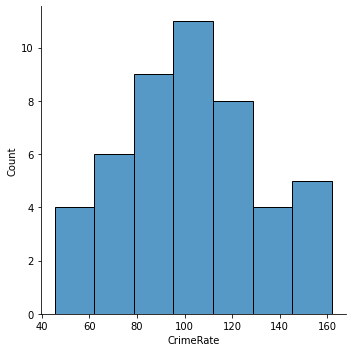

In [174]:
# Plot distribution of the Crime Rate variable
sns.displot(data = df, x = "CrimeRate");

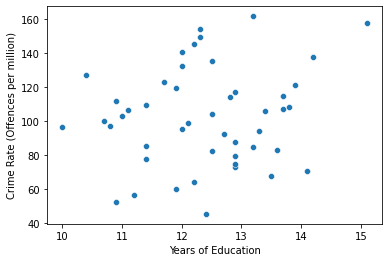

In [177]:
# Plot data
sns.scatterplot(x = "Education", y = "CrimeRate", data=df);
plt.xlabel('Years of Education');
plt.ylabel('Crime Rate (Offences per million)');

# Step 2 - Define the descriptive statistical model \begin{align*}
y_i &\sim Student(\nu, \mu, \sigma) 
\\ \nu  &\sim Gamma(2, .1)
\\ \mu_i &= \beta_0 + \beta_1x
\\ \beta_0 &\sim Normal(0, 1)
\\ \beta_1 &\sim Normal(0, 1)
\\ \sigma &\sim Exponential(1)
\end{align*} 

<font size = "3">The formulation for presenting statistical models here follows that used by McElreath (2020) for its intuitive nature. In plain english the model specifies that the dependent variable $y_i$ follows a student-t distribution. Therefore, there are three parameters to specify $\nu, \mu, \sigma$, each with their own prior distributions. $\nu$ has a $Gamma(2, .1)$ distribution. The $\mu$ is made up of the linear model $\mu_i = \beta_0 + \beta_1x$, each of these $\beta$ parameters are given $Normal(0,1)$ priors. Finally, the $\sigma$ given and $Exponential(1)$.

# Step 3 - Specifying priors

The specifification of priors above can be viewed as a set pragamatic choices for the analysis, that are common in Bayesian analysis when the data is standardised and uses a Student-t likelihood Juárez and Steel(2010).

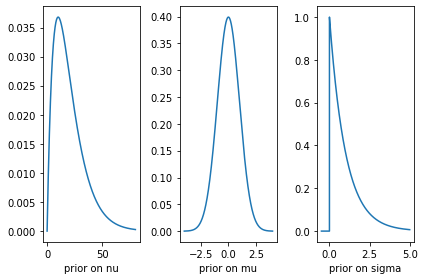

In [130]:
# Visualise the priors selcted for all of the model parameters.
plt.subplot(1, 3, 1)
x = np.arange(-.0, 80, 0.001)
plt.plot(x, stats.gamma.pdf(x, a = 2, scale = 1/.1));
plt.xlabel("Prior on Nu");

plt.subplot(1, 3, 2)
x = np.arange(-4, 4, 0.001)
plt.plot(x, stats.norm.pdf(x, loc=0, scale=1));
plt.xlabel("prior on Mu");

# Visualise prior on Standard deviation parameter.
plt.subplot(1, 3 ,3)
x = np.arange(-.5, 5, 0.001)
plt.plot(x, stats.expon.pdf(x, scale = 1));
plt.xlabel("Prior on sigma");
plt.tight_layout()

# Step 4 - Use Bayes rule.

The software of choice to conduct Bayesian inference on the data here is Stan and the model is specified below.

# Stan model of a Bayesian robust regression

In [162]:
Robust_Regression = """
data {
  int N;   // Sample size
  int K;   // Number of predictor variables
  matrix[N, K] x;   // Predictor variable (IV) matrix
  vector[N] y;      // Vector of Dependent variable (DV) values
}
parameters{
real<lower = 1> nu;  // degrees of freedom       
vector[K] beta;       // Coefficients for intercept and predictors
real<lower = 0> sigma;  // Standard deviation
}
transformed parameters{
vector[N] mu;
mu =  x * beta;
}
model {

//priors
nu ~ gamma(2, .1);

// Vectorised so given each beta parameter the same prior
beta ~ std_normal();

// Maximum entropy prior for sigma term
sigma ~ exponential(1);

//Likelihood
y ~ student_t(nu, mu, sigma);  // likelihood
}
generated quantities{
real yrep[N] = student_t_rng(nu, mu, sigma);
}
"""

In [179]:
# Standardise the predictor variable
df['Education_std'] = standardise(df['Education'].values)
# Generate design matrix for regression
dm = np.asarray(dmatrix(" ~ Education_std", data = df))
# Generate python dictionary to pass to Stan
data = {'N': len(df),
        'K': np.shape(dm)[1],
        'x': dm,
        'y': standardise(df["CrimeRate"].values)}

In [164]:
# StanModel function can be called and be passed the model string specified above to compile into C++ code.
sm  = ps.build(Robust_Regression, data = data)

Building...



Building: 40.6s, done.

In [190]:
fit = sm.sample(num_chains = 4, num_samples = 1000)

Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: student_t_lpdf: Scale parameter is 0, but must be positive finite! (in '/tmp/httpstan_9_k1g1qh/model_hr3szi3r.stan', line 29, column 0 to column 29)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either

In [191]:
az.summary(fit, var_names= ['nu', 'beta', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
nu,24.543,14.548,3.691,50.883,0.228,0.167,3520.0,2393.0,1.0
beta[0],-0.003,0.153,-0.297,0.283,0.002,0.002,3808.0,2553.0,1.0
beta[1],0.141,0.148,-0.145,0.417,0.002,0.002,4172.0,2772.0,1.0
sigma,0.989,0.115,0.794,1.219,0.002,0.001,3838.0,2824.0,1.0


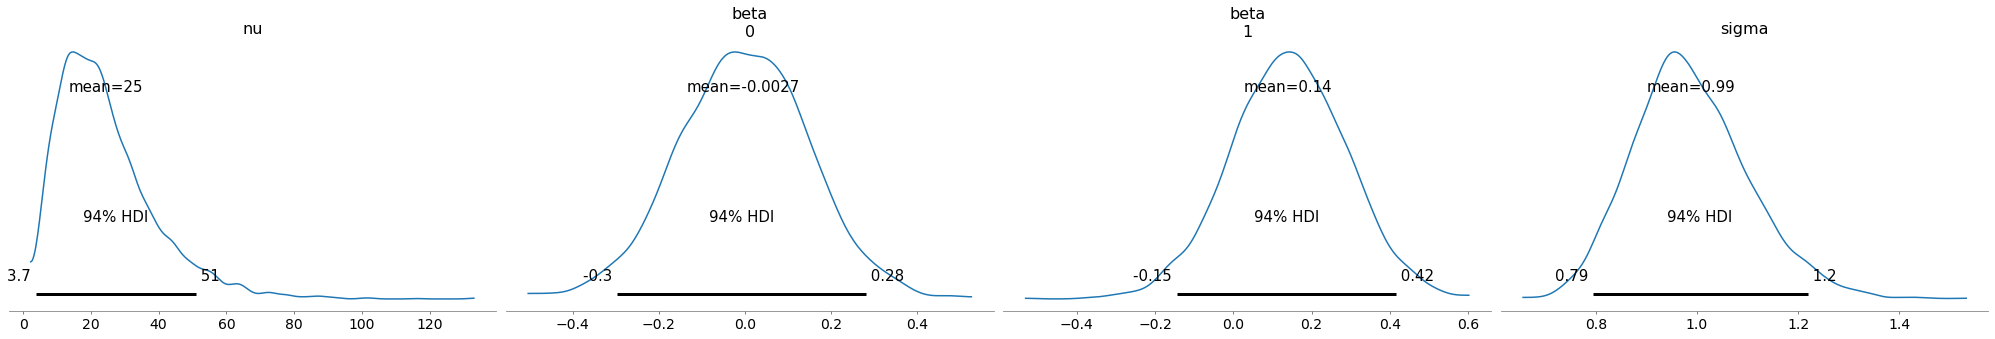

In [192]:
az.plot_posterior(fit, var_names= ['nu', 'beta', 'sigma']);

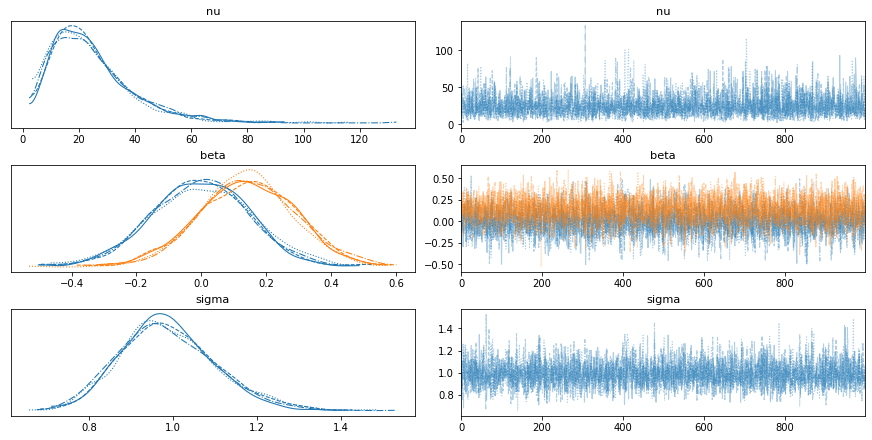

In [193]:
az.plot_trace(fit, ['nu', 'beta', 'sigma']);

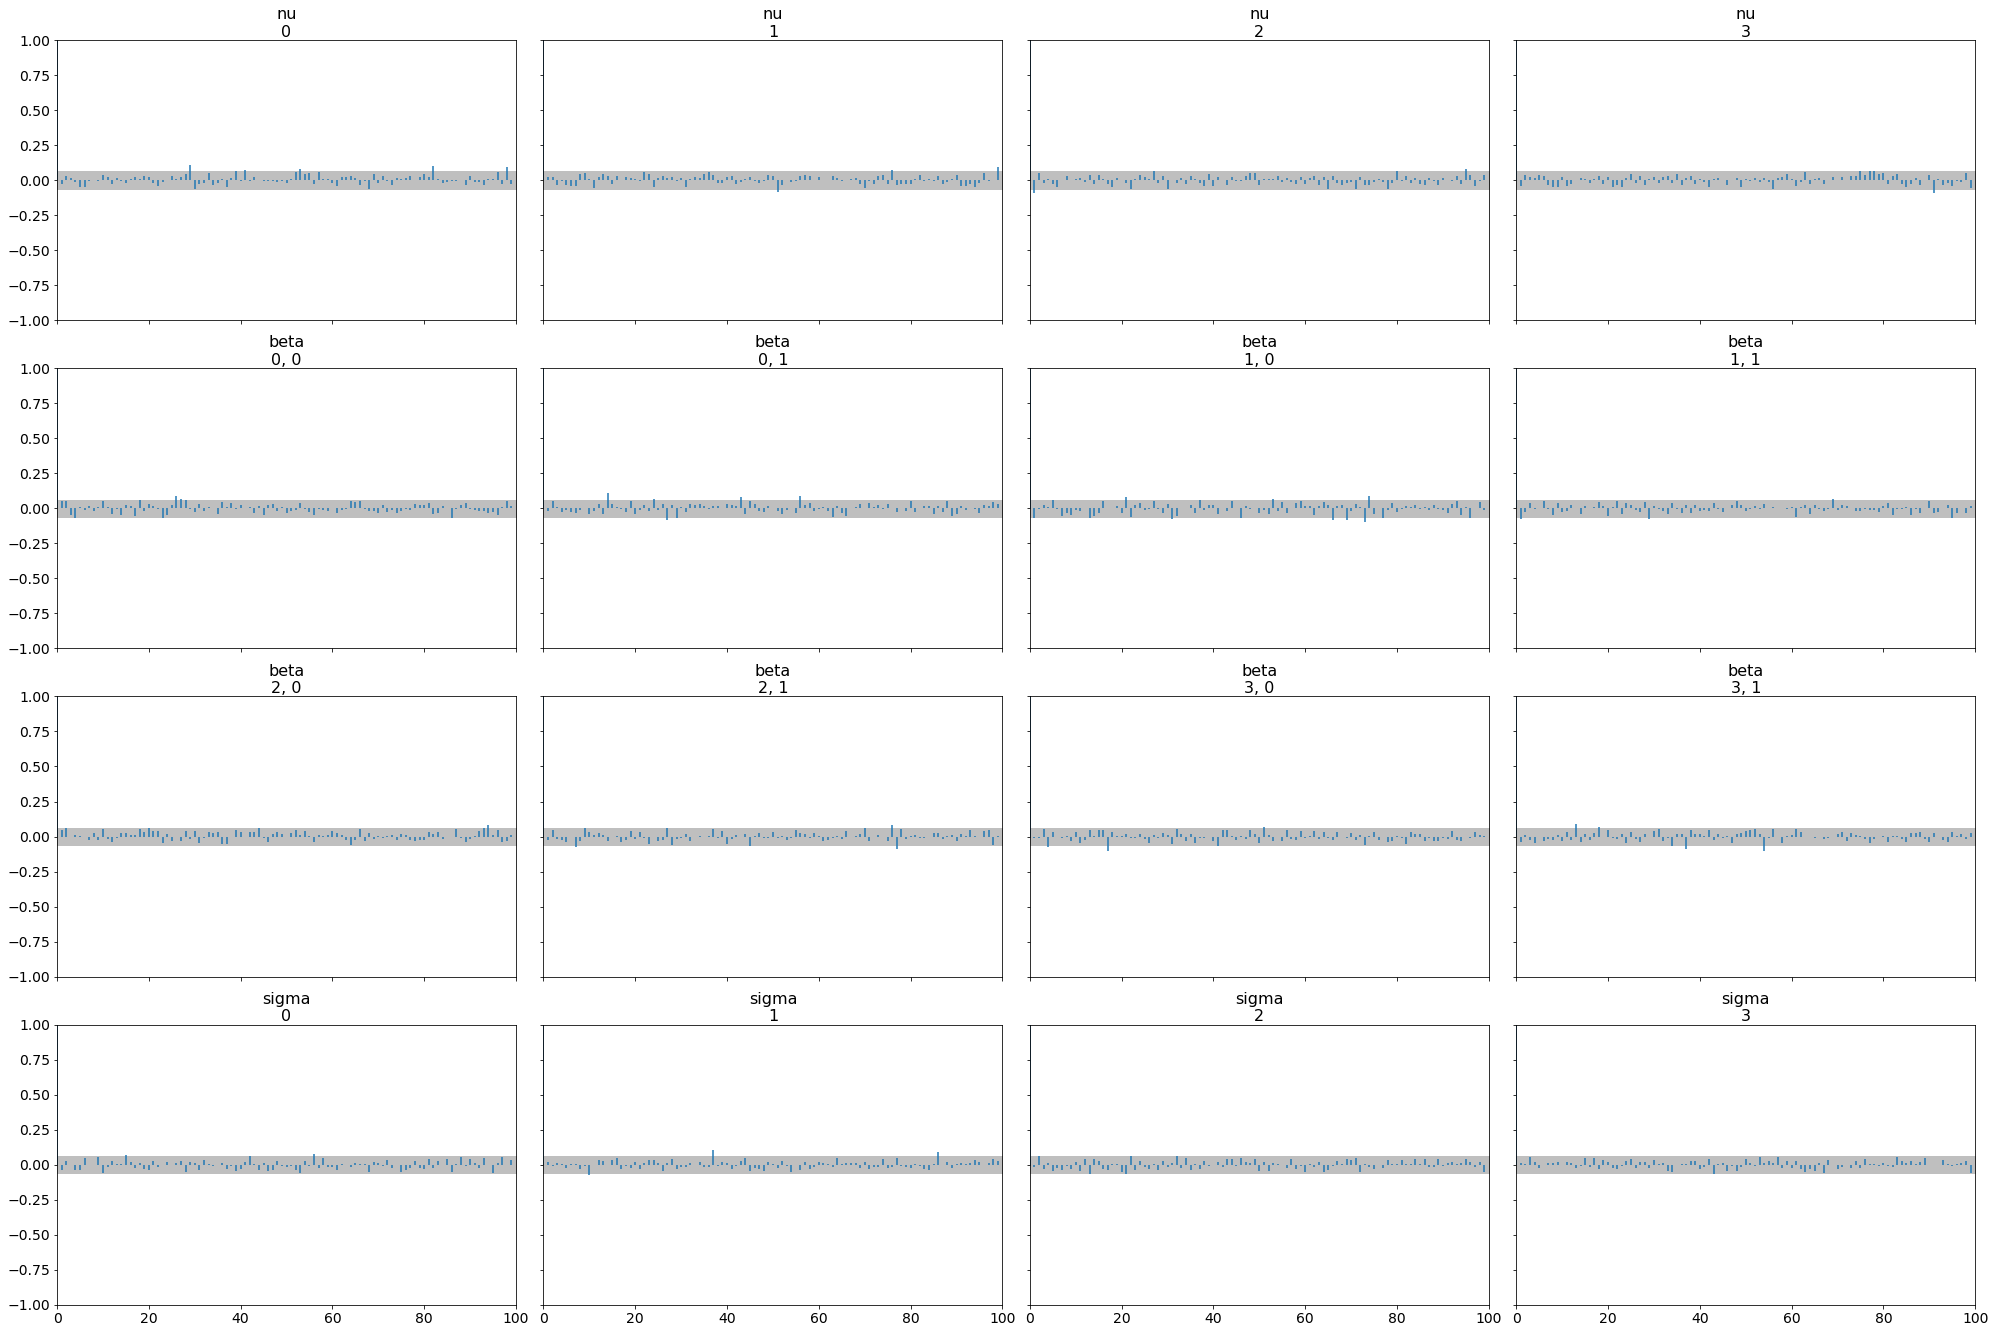

In [183]:
az.plot_autocorr(fit, var_names = ['nu', 'beta', 'sigma']);

Autocorrelation plots show now issues with all chain values quickly returning to 0.

## Identifiablity of $\nu$ parameters

What the fitted model here nicely demonstrates the difficulty in estimating the $\nu$ parameter of student-t likelihoods. As the posteriors nicely show above is that estiamted $\nu$ parameters distribution is almost identical to the prior distribution. This means that the data has provided little to no conditional information to inform infernce on that parameter

# Step 5 - Posterior predictive checks

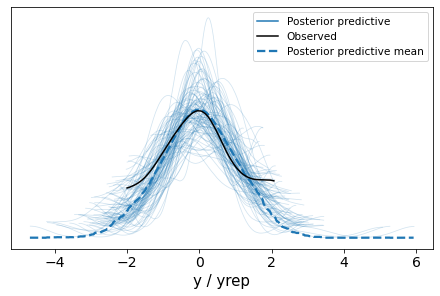

In [169]:
#Convert pystan fit object to IO for Arviz functions.
idata = az.from_pystan(posterior=fit,posterior_model = sm, posterior_predictive=['yrep'], observed_data= 'y')
# Plot posterior simulated data sets for posterior predictive check
az.plot_ppc(idata, data_pairs = {"y" : "yrep"}, num_pp_samples= 100);

The posterior predictive distribution suggests a poor fit between the model and the observed data. With a large number of the simulated datasets predicting extreme values of -4:4 standard deviations compared to the observed dataset. Additionally, some of predictive datasets values were very narrow compared to the obsserved data. This is a result of the great uncertainty of $\nu$ parameter thats prior was not updated when conditioned on the data.

This however is a good example where many of suggestions for a defualt to robust analysis are not automatically the most appropriate option (Kruschke, 2013, 2015). There are many considerations with any modelling choice. These choices are usually determined by the analysis goal. The model above for purely estimation is unlikely to perform radically diffent to a normal likelihood model. However, for prediction it will likely perform worse, of course, the only way to test this would be with replication and observing new data.

# Reporting the results of the Bayesian robust regression

<font size = "3">As Kruschke correctly points out there is no standard formula or presentation method for results in a journal article like the APA guide for reporting frequentist analysis. It is likely there never will be, because as McElreath (2020) explains Bayesian data analysis is more like a engineering approach to the problem and the resulting model that is fit will be analysis specific. In addition, as Gabry et al, (2017) argue visualisations maybe even more key so the all the visualisations above would have to be included with any write up. Anyway,  the write up below generally follows the advice of Kruschke (2015) chapter 25. In any application though it comes down to the problem to be described an the audience that needs to be convinced. </p><br/>

<h2>Write up</h2><br/>

# References

Juárez, M. A., & Steel, M. F. (2010). Model-based clustering of non-Gaussian panel data based on skew-t distributions. Journal of Business & Economic Statistics, 28(1), 52-66.

Kruschke, J. K. (2013). Bayesian estimation supersedes the t test. Journal of Experimental Psychology: General, 142(2), 573.

Kruschke, J. (2015). Doing Bayesian data analysis: A tutorial with R, JAGS and Stan. Oxford, England: Academic Press. 

McElreath, R. (2020). Statistical rethinking: A Bayesian course with examples in R and Stan.Boca Raton: CRC Press.